Importing libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

Reading the file 

In [23]:
data = pd.read_csv(r'C:\Users\radek\IronHack\IronRadek\Week7\Project7_Supervised_Learning\data_encoded.csv')

In [24]:
data.head()

,year,kind,rating,vote,country,runtime,genre1,genre2
0,2003.0,2,7.7,474.0,62,50.000000,6,2
1,1994.0,7,8.1,18.0,62,83.000000,8,27
2,1992.0,1,5.5,93.0,37,102.887743,0,20
3,2004.0,1,5.3,13432.0,62,60.000000,6,4
4,1991.0,1,4.5,2177.0,62,96.000000,4,13


In [25]:
data['score']= pd.cut(data.rating, bins=[0,5.5,7,10], labels=[0,1,2])

In [6]:
data.head()

,year,kind,rating,vote,country,runtime,genre1,genre2,score
0,2003.0,2,7.7,474.0,62,50.000000,6,2,3
1,1994.0,7,8.1,18.0,62,83.000000,8,27,3
2,1992.0,1,5.5,93.0,37,102.887743,0,20,1
3,2004.0,1,5.3,13432.0,62,60.000000,6,4,1
4,1991.0,1,4.5,2177.0,62,96.000000,4,13,1


In [26]:
data.drop(columns='rating',inplace=True)

In [42]:
data.head()

,year,kind,vote,country,runtime,genre1,genre2,score
0,2003.0,2,474.0,62,50.000000,6,2,3
1,1994.0,7,18.0,62,83.000000,8,27,3
2,1992.0,1,93.0,37,102.887743,0,20,1
3,2004.0,1,13432.0,62,60.000000,6,4,1
4,1991.0,1,2177.0,62,96.000000,4,13,1


In [27]:
data.score.value_counts()

2    3438
1    3091
0    1386
Name: score, dtype: int64

We should have an integer number as a traget. Since rating is our target and it is a float, we will change it into an integer

In [44]:
data.dtypes

year        float64
kind          int64
vote        float64
country       int64
runtime     float64
genre1        int64
genre2        int64
score      category
dtype: object

In [28]:
data.head()

,year,kind,vote,country,runtime,genre1,genre2,score
0,2003.0,2,474.0,62,50.000000,6,2,2
1,1994.0,7,18.0,62,83.000000,8,27,2
2,1992.0,1,93.0,37,102.887743,0,20,0
3,2004.0,1,13432.0,62,60.000000,6,4,0
4,1991.0,1,2177.0,62,96.000000,4,13,0


We dfine X and y 

In [29]:
X= data.drop('score', axis=1)
y=data['score']

# Features Selection

We start with Select from model

In [47]:
SFM = SelectFromModel(estimator=RandomForestClassifier())
s=SFM.fit(X, y)

In [48]:
n_features = s.transform(X).shape[1]

print(f'Number of features: {n_features}')
feature_idx = s.get_support()
feature_name = X.columns[feature_idx]
print(f'Features selected:\n{feature_name}') 

Number of features: 3
Features selected:
Index(['year', 'vote', 'runtime'], dtype='object')


RFE

In [49]:
rfe_selector = RFE(estimator=RandomForestClassifier())
m=rfe_selector.fit(X, y)
X.columns[m.get_support()]
print("Num Features: %s" % (m.n_features_))
print("Selected Features: %s" % (m.support_))
print("Feature Ranking: %s" % (m.ranking_))

Num Features: 3
Selected Features: [ True False  True False  True False False]
Feature Ranking: [1 5 1 4 1 2 3]


RFECV

In [50]:
rfecv = RFECV(
    estimator=RandomForestClassifier(),
    min_features_to_select=2,
    step=1,
    n_jobs=-1,
    verbose=1,
    scoring="r2",
    cv=5,
)

m= rfecv.fit(X, y)

In [51]:
X.columns[rfecv.support_]

Index(['year', 'kind', 'vote', 'country', 'runtime', 'genre1', 'genre2'], dtype='object')

The two first methods of feature selection suggested to take only year, vote and runtime, but since we used label encoder to encode data, we do not have a lot of columns/features. Therefore we will take all of out freatures for our models

# Hyperparameters tuning

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## RidgeClassifier

Classifier using Ridge regression.

This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).

It is necessary to standarize data before using Ridge Classifier

In [17]:
X_stand = StandardScaler().fit_transform(X)

In [58]:
grid_search = GridSearchCV(RidgeClassifier(),
                           {  'alpha':np.arange(100,800,100),
                              'max_iter':np.arange(1,20,1),
                              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
                              'normalize' : [True, False]
                            },
                            cv=3, scoring="accuracy",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_stand,y)

Fitting 3 folds for each of 2128 candidates, totalling 6384 fits


GridSearchCV(cv=3, estimator=RidgeClassifier(), n_jobs=-1,
             param_grid={'alpha': array([100, 200, 300, 400, 500, 600, 700]),
                         'max_iter': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'normalize': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             scoring='accuracy', verbose=1)

In [59]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 200, 'max_iter': 1, 'normalize': False, 'solver': 'sag'}
0.4851560298215287


In [60]:
rand_search = RandomizedSearchCV(RidgeClassifier(),
                           {  'alpha':np.arange(100,800,100),
                              'max_iter':np.arange(1,20,1),
                              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
                              'normalize' : [True, False]
                            }
                            ,cv=5, scoring="balanced_accuracy",verbose=1,n_jobs=-1
                           )
rand_search.fit(X_stand,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RidgeClassifier(), n_jobs=-1,
                   param_distributions={'alpha': array([100, 200, 300, 400, 500, 600, 700]),
                                        'max_iter': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'normalize': [True, False],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga', 'lbfgs']},
                   scoring='balanced_accuracy', verbose=1)

In [61]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'solver': 'cholesky', 'normalize': False, 'max_iter': 2, 'alpha': 100}
0.38744073578964333


## SVC 

In [63]:
grid_search = GridSearchCV(SVC(),
                           {"gamma": ['scale', 'auto'] , 
                           "C": range(1, 10),
                           
                           }
                           ,cv=5, scoring="balanced_accuracy",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_stand,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': range(1, 10), 'gamma': ['scale', 'auto']},
             scoring='balanced_accuracy', verbose=1)

In [64]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 9, 'gamma': 'scale'}
0.5165969222750021


In [65]:
rand_search = RandomizedSearchCV(SVC(),
                             {"gamma": ['scale', 'auto'] , 
                           "C": range(1, 10)},
                           cv=5, scoring="accuracy",verbose=1,n_jobs=-1
                           )
rand_search.fit(X_stand,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': range(1, 10),
                                        'gamma': ['scale', 'auto']},
                   scoring='accuracy', verbose=1)

In [66]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'gamma': 'auto', 'C': 9}
0.5724573594440934


## Categorical Naive Bayes Classifier

Naïve Bayes classifiers are a family of probabilistic classifiers based on Bayes Theorem with a strong assumption of independence between the features. These are not only fast and reliable but also simple and easiest classifier which is proving its stability in machine learning world. Despite its simplicity, it gives accurate prediction in text classification problems.

In [75]:
grid_search = GridSearchCV(CategoricalNB(),
                           {'alpha':np.arange(0,1.1,0.1),
                           'fit_prior' : [True, False],
                           'min_categories' : np.arange(1,10)
                           },
         cv=5, scoring="accuracy",verbose=1,n_jobs=-1
                           )
grid_search.fit(X,y)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


GridSearchCV(cv=5, estimator=CategoricalNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'fit_prior': [True, False],
                         'min_categories': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy', verbose=1)

In [76]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 0.0, 'fit_prior': True, 'min_categories': 1}
nan


In [31]:
rand_search = RandomizedSearchCV(CategoricalNB(),
                           {'alpha':np.arange(100,800,100),
                           'fit_prior' : [True, False],
                           'min_categories' : np.arange(1,10)
                           },
         ,cv=5, scoring="accuracy",verbose=1,n_jobs=-1
                           )
rand_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=CategoricalNB(), n_jobs=-1,
                   param_distributions={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'min_categories': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   scoring='accuracy', verbose=1)

In [33]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'min_categories': 7, 'alpha': 0.5}
nan


In [77]:
m=CategoricalNB(min_categories= 7).fit(X,y)

In [78]:
m.score(X,y)

0.7355653821857233

## Extra Trees Classifier

ExtraTreesClassifier

In [12]:
# I commented this part of code not to rerun it again as it took almost 200 minutes to run this cell

# grid_search = GridSearchCV(ExtraTreesClassifier(),
#                            {
#                               'n_estimators':np.arange(200,250,5),
#                               'max_depth': np.arange(1,20,2),
#                               'criterion' : ["gini", "entropy"],
#                               'max_depth': np.arange(1,20),
#                               'min_samples_split': np.arange(1,20),
#                               'oob_score' : [True,False],
#                               'class_weight': ['balanced', 'balanced_subsample']


                            
#                             },cv=2, scoring="accuracy",verbose=1,n_jobs=-1
#                            )
# grid_search.fit(X,y)

Fitting 2 folds for each of 28880 candidates, totalling 57760 fits


GridSearchCV(cv=2, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'n_estimators': array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245]),
                         'oob_score': [True, False]},
             scoring='accuracy', verbose=1)

In [13]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 225, 'oob_score': False}
0.6573588959025543


In [10]:
rand_search = RandomizedSearchCV(ExtraTreesClassifier(),
                           {
                            'n_estimators':np.arange(200,250,5),
                              'max_depth': np.arange(1,20,2),
                              'criterion' : ["gini", "entropy"],
                              'max_depth': np.arange(1,20),
                              'min_samples_split': np.arange(1,20),
                              'oob_score' : [True,False],
                              'class_weight': ['balanced', 'balanced_subsample']
                            
                            },cv=5, scoring="accuracy",verbose=1,n_jobs=-1
                           )
rand_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245]),
                                        'oob_score': [True, False]},
                   scoring='accuracy', verbose=1)

In [11]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'oob_score': False, 'n_estimators': 225, 'min_samples_split': 12, 'max_depth': 19, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}
0.6600126342387871


# Models testing

In [19]:
def generate_results(model, predictions, name):
    cl_rep = classification_report(y_test, predictions)
    print("\nThe classification report for " + name + " is:", cl_rep, sep = "\n")
    cm_model = confusion_matrix(y_test, predictions)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm_model, annot = True, cmap = 'Blues', annot_kws = {'size': 15}, square = True)
    plt.title('Confusion Matrix for ' + name, size = 15)
    plt.xticks(size = 15)
    plt.yticks(size = 15)
    plt.show() 

Split the data into train and test

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6332, 7)
(6332,)
(1583, 7)
(1583,)


Now lets split standarized data into train and test for SVC and Ridge Classifier models

In [31]:
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(X_stand, y, test_size=0.2, random_state=5)
print(x_train_st.shape)
print(y_train_st.shape)
print(x_test_st.shape)
print(y_test_st.shape)

(6332, 7)
(6332,)
(1583, 7)
(1583,)


## Ridge Classifier

For this model through hyperparameter testing we established that optimal parameter are:
- 'alpha': 200, 
- 'max_iter': 1, 
- 'normalize': False, 
- 'solver': 'sag'

The accuracy for Ridge Classifier is: 49.90524320909665 %

The classification report for Ridge Classifier is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       280
           1       0.46      0.60      0.52       613
           2       0.54      0.61      0.57       690

    accuracy                           0.50      1583
   macro avg       0.33      0.40      0.36      1583
weighted avg       0.41      0.50      0.45      1583



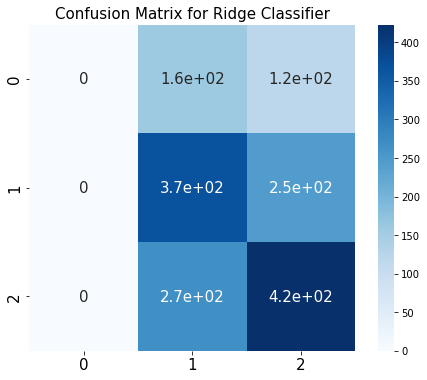

In [32]:
rc = RidgeClassifier(alpha=200, max_iter=1, normalize=False, solver='sag')
rc.fit(x_train_st, y_train_st)
y_pred = rc.predict(x_test_st)
acc_rc = rc.score(x_test_st, y_test_st)
print('The accuracy for Ridge Classifier is:', acc_rc * 100, "%")
generate_results(rc, y_pred, 'Ridge Classifier')

## SVC

Based on the hyperparameter tuning we established that the best parameters are: 
- 'C': 9, 
- 'gamma': auto

The accuracy for SVC is: 59.50726468730259 %

The classification report for SVC is:
              precision    recall  f1-score   support

           0       0.62      0.30      0.40       280
           1       0.53      0.69      0.60       613
           2       0.67      0.64      0.65       690

    accuracy                           0.60      1583
   macro avg       0.61      0.54      0.55      1583
weighted avg       0.61      0.60      0.59      1583



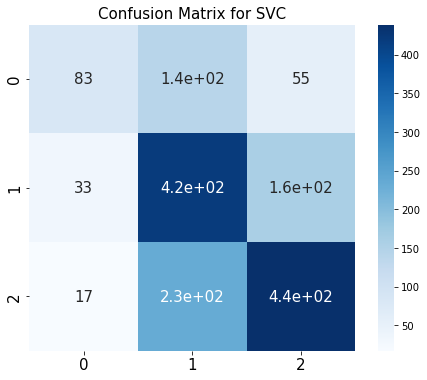

In [33]:
svc = SVC(C=9,gamma='auto')
svc.fit(x_train_st, y_train_st)
y_pred = svc.predict(x_test_st)
acc_svc = svc.score(x_test_st, y_test_st)
print('The accuracy for SVC is:', acc_svc * 100, "%")
generate_results(svc, y_pred, 'SVC')

## Categorical NB Classifier

The best parameters after hyperparameters tuning are:
- 'alpha': 0.0, 
- 'fit_prior': True, 
- 'min_categories': 1} 


The accuracy for cNB is: 50.97915350600126 %

The classification report for cNB is:
              precision    recall  f1-score   support

           0       0.37      0.45      0.40       280
           1       0.48      0.48      0.48       613
           2       0.61      0.57      0.59       690

    accuracy                           0.51      1583
   macro avg       0.49      0.50      0.49      1583
weighted avg       0.52      0.51      0.51      1583



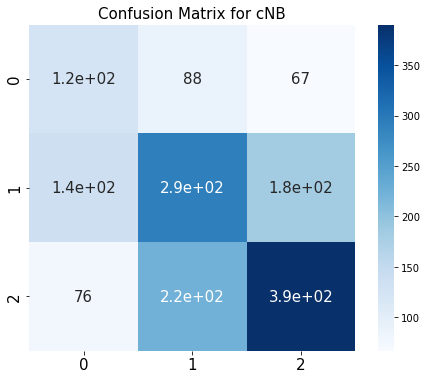

In [34]:
cNB = CategoricalNB(min_categories=1,alpha=0.0, fit_prior=True)
cNB.fit(x_train, y_train)
y_pred = cNB.predict(x_test)
acc_cNB = cNB.score(x_test, y_test)
print('The accuracy for cNB is:', acc_cNB * 100, "%")
generate_results(cNB, y_pred, 'cNB')

## Extra Trees CLassifier

After hyperparameter tunning we know that the best parameters are: 
- 'class_weight': 'balanced_subsample', 
- 'criterion': 'gini', 
- 'max_depth': 18, 
- 'min_samples_split': 2, 
- 'n_estimators': 225, 
- 'oob_score': False

The accuracy for Extra Trees Classifier is: 67.150979153506 %

The classification report for Extra Trees Classifier is:
              precision    recall  f1-score   support

           0       0.60      0.54      0.56       280
           1       0.61      0.66      0.64       613
           2       0.76      0.73      0.74       690

    accuracy                           0.67      1583
   macro avg       0.66      0.64      0.65      1583
weighted avg       0.67      0.67      0.67      1583



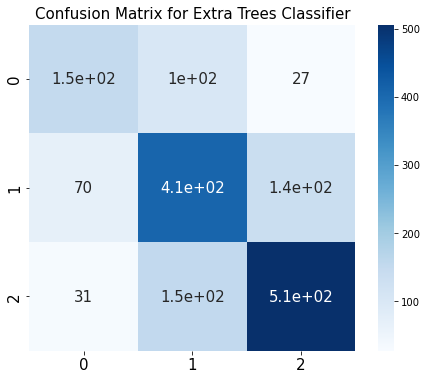

In [38]:
etc = ExtraTreesClassifier(n_estimators=226,max_depth=19, class_weight='balanced_subsample', criterion='gini', min_samples_split=2, oob_score=False)
etc.fit(x_train, y_train)
y_pred = etc.predict(x_test)
acc_etc = etc.score(x_test, y_test)
print('The accuracy for Extra Trees Classifier is:', acc_etc * 100, "%")
generate_results(etc, y_pred, 'Extra Trees Classifier')